# Making a light curve for AO Her from FFI data

### runs in notebook_lk

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/Users/ccra8514/anaconda3/envs/notebook_lk/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/ccra8514/.lightkurve/cache. Please move all the files in the legacy directory /Users/ccra8514/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
target = 'TIC 362082660'

Search for the FFI data using lightkurve and TESS Cut

In [3]:
search_result = lk.search_tesscut(target)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 24,2020,TESScut,1426,TIC 362082660,0.0
1,TESS Sector 25,2020,TESScut,1426,TIC 362082660,0.0
2,TESS Sector 26,2020,TESScut,1426,TIC 362082660,0.0
3,TESS Sector 40,2021,TESScut,475,TIC 362082660,0.0
4,TESS Sector 51,2022,TESScut,475,TIC 362082660,0.0
5,TESS Sector 52,2022,TESScut,475,TIC 362082660,0.0
6,TESS Sector 53,2022,TESScut,475,TIC 362082660,0.0


Let's focus on one sector for now

In [4]:
tpf = search_result[0].download(cutout_size=20)

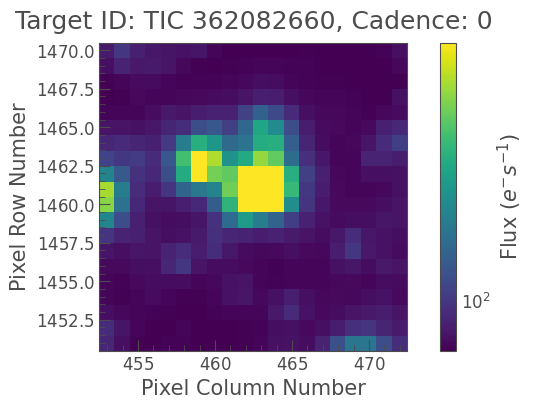

In [5]:
tpf.plot(scale='log');

Will need to create an aperture mask for the target that doesn't include the nearby star

In [6]:
mask = tpf.create_threshold_mask()

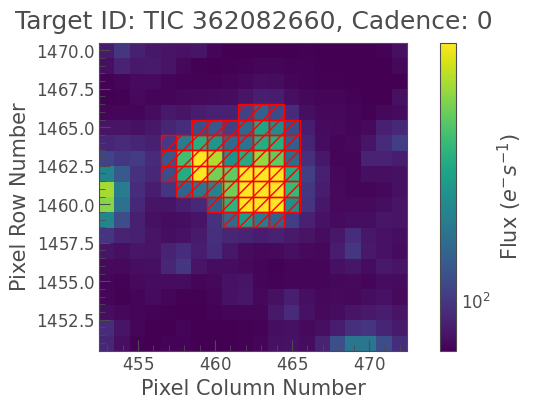

In [7]:
tpf.plot(scale='log',aperture_mask=mask);

Nope, the default threshold is too low, let's experiment to make it higher

In [8]:
mask = tpf.create_threshold_mask(threshold=37)

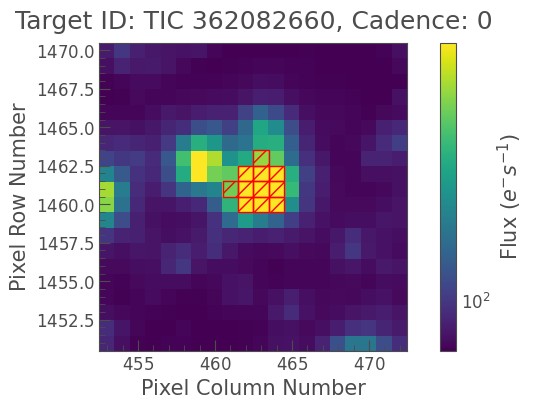

In [9]:
tpf.plot(scale='log',aperture_mask=mask);

In [10]:
lc = tpf.to_lightcurve(aperture_mask = mask)

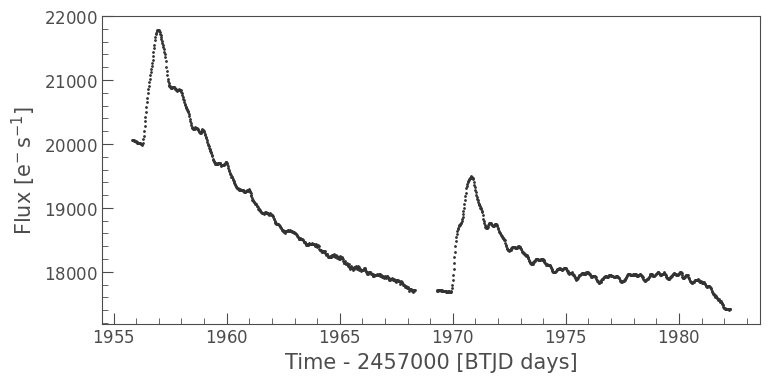

In [11]:
lc.scatter();

Now that obviously includes a lot of background flux that we'd like to get rid of. So now create a mask of background pixels.

In [12]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)

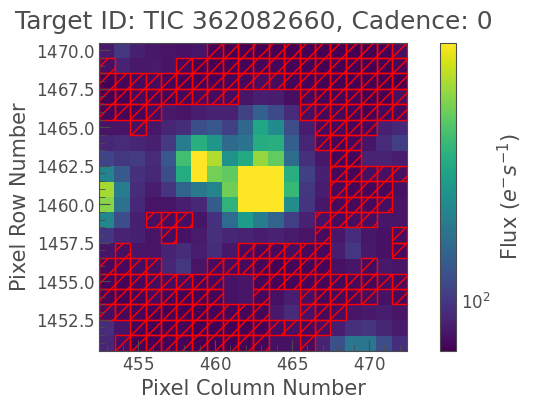

In [13]:
tpf.plot(scale='log',aperture_mask=background_mask);

Create an average background light curve per pixel

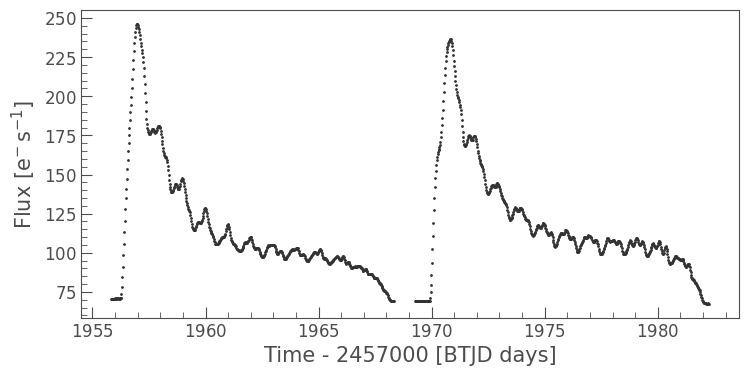

In [14]:
n_background_pixels = background_mask.sum()

background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels

background_lc_per_pixel.scatter();

Multiply by the number of pixels in the target mask to estimate contribution to the light curve

In [15]:
n_target_pixels = mask.sum()
background_estimate_lc = background_lc_per_pixel * n_target_pixels

And subtract

In [16]:
corrected_lc = lc - background_estimate_lc.flux

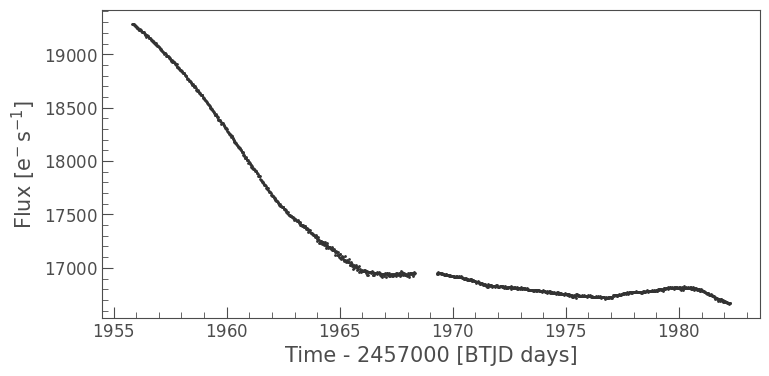

In [17]:
corrected_lc.scatter();

Now repeat for other sectors:

In [18]:
result_lc = corrected_lc.copy()

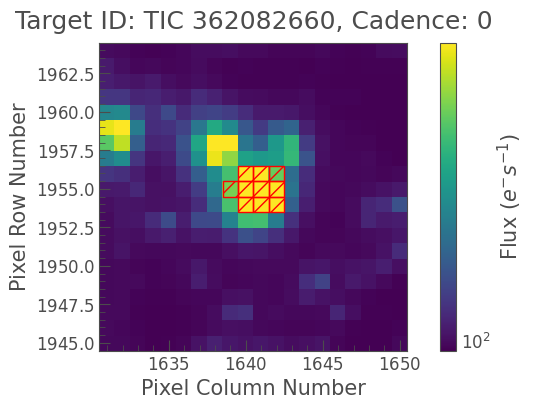

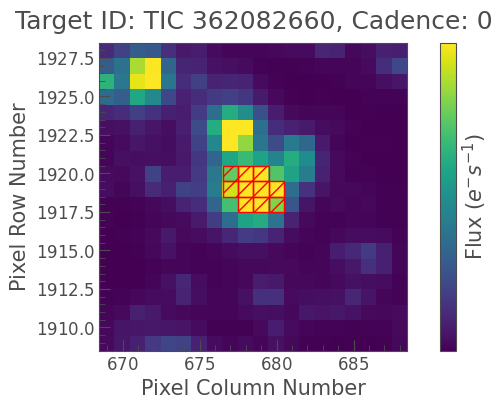

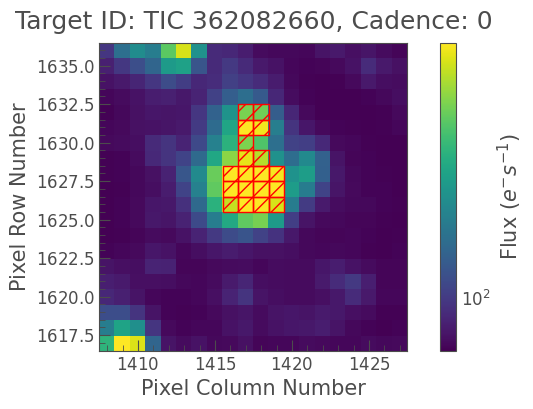

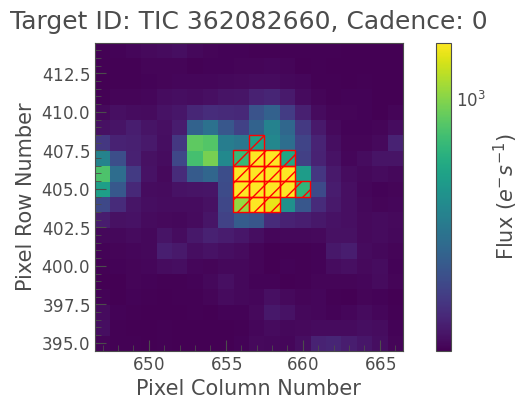

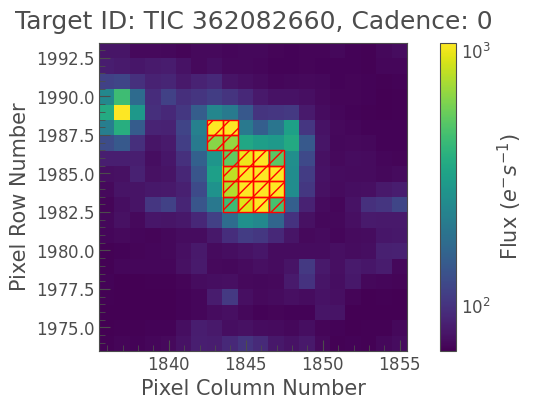

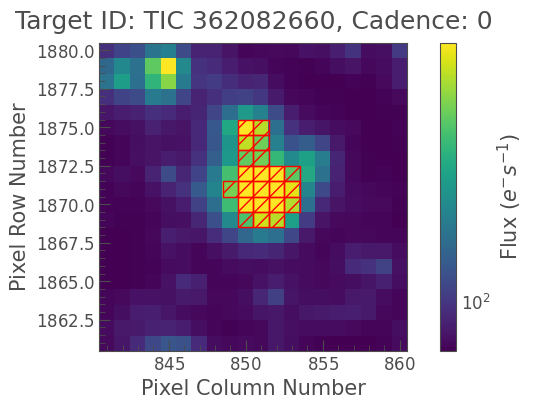

In [19]:
for result in search_result[1:]:
    tpf = result.download(cutout_size=20)
    
    mask = tpf.create_threshold_mask(threshold=37)
    
    tpf.plot(scale='log',aperture_mask=mask);
    
    lc = tpf.to_lightcurve(aperture_mask = mask)
    
    background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    
    n_target_pixels = mask.sum()
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    
    corrected_lc = lc - background_estimate_lc.flux
    
    result_lc = result_lc.append(corrected_lc)

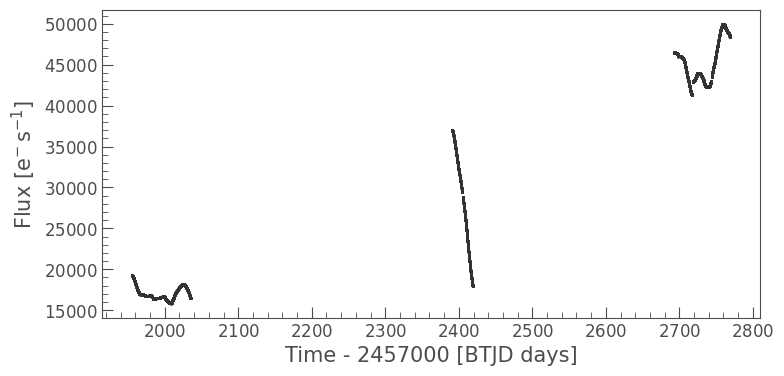

In [20]:
result_lc.scatter();

Ok, so it turns out the threshold for the target mask is too low in the later sectors, so it's getting contaminated by the other star. But let's look at where it was successful...

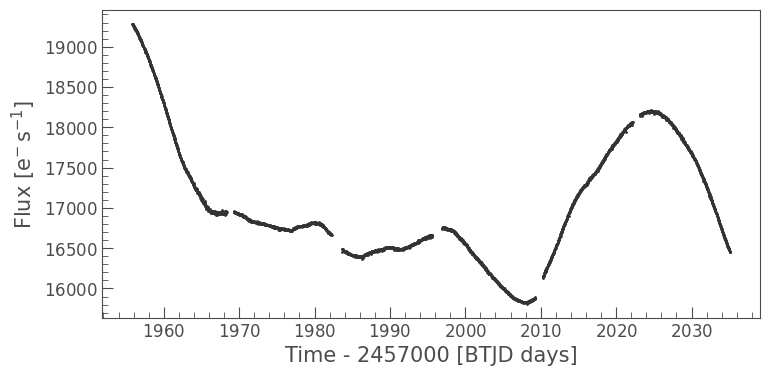

In [21]:
result_lc[result_lc.time.value < 2100].scatter();

In [22]:
time = result_lc[result_lc.time.value < 2100].time.value
flux = result_lc[result_lc.time.value < 2100].flux.value

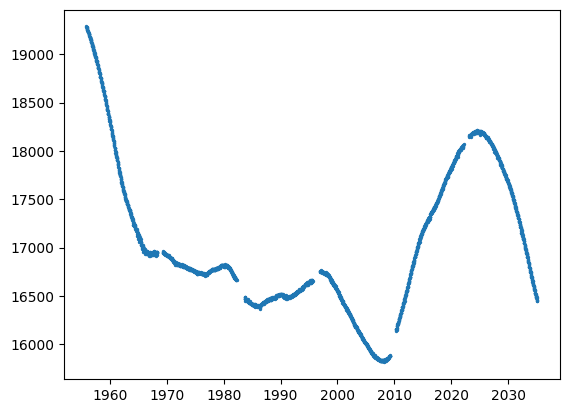

In [23]:
plt.scatter(time,flux,s=2)
plt.show()

In [24]:
from astropy.timeseries import LombScargle
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 10 # was 360 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [25]:
freq,amp = calc_lomb_scargle(time,flux)

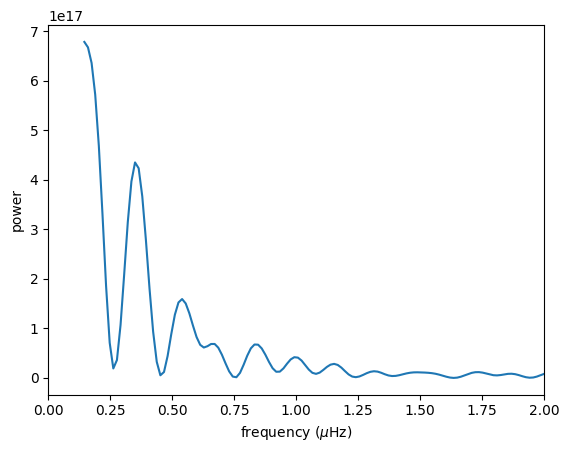

In [26]:
plt.plot(freq,amp**2)
plt.xlim(0,2)
# plt.axvline(0.03,color='k')
plt.xlabel(r'frequency ($\mu$Hz)')
plt.ylabel('power')
plt.show()

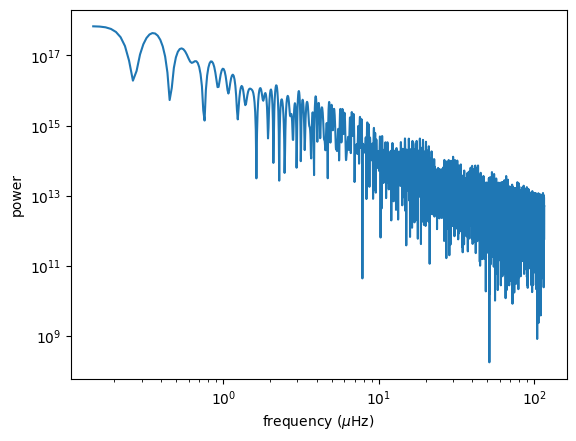

In [27]:
plt.plot(freq,amp**2)
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0,5)
plt.xlabel(r'frequency ($\mu$Hz)')
plt.ylabel('power')
plt.show()

So the other sectors are going to need a different threshold mask. Let's just create a function to do all the mask creation and background correction stuff:

In [28]:
def create_lc(tpf,threshold=3,plot_mask=False):

    mask = tpf.create_threshold_mask(threshold=threshold)
    
    if plot_mask:
        tpf.plot(scale='log',aperture_mask=mask);
    
    lc = tpf.to_lightcurve(aperture_mask = mask)
    
    background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    
    n_target_pixels = mask.sum()
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    
    corrected_lc = lc - background_estimate_lc.flux
    
    return corrected_lc

In [29]:
tpf = search_result[3].download(cutout_size=20) #Sector 40

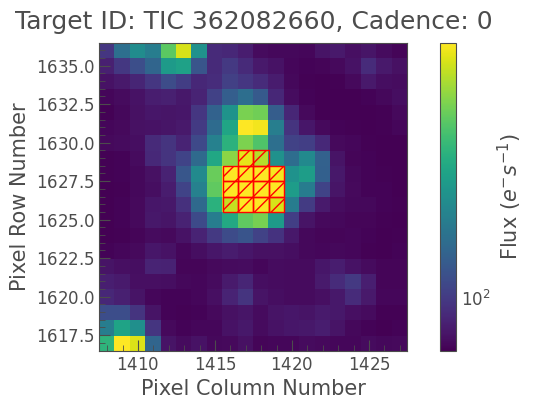

In [30]:
lc40 = create_lc(tpf, threshold=40, plot_mask=True)

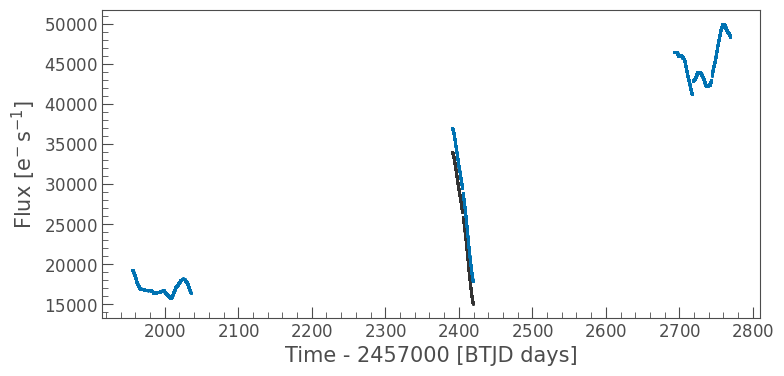

In [31]:
ax = lc40.scatter();
result_lc.scatter(ax=ax);

Oh so that big drop in flux seems to be real. Let's look at the other sectors...

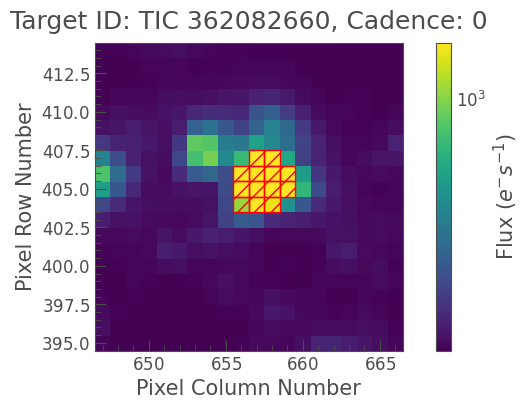

In [32]:
tpf = search_result[4].download(cutout_size=20) #Sector 51
lc51 = create_lc(tpf, threshold=60, plot_mask=True)

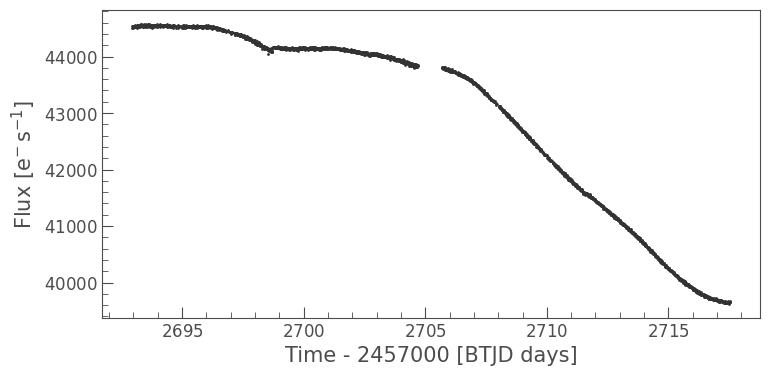

In [33]:
lc51.scatter();

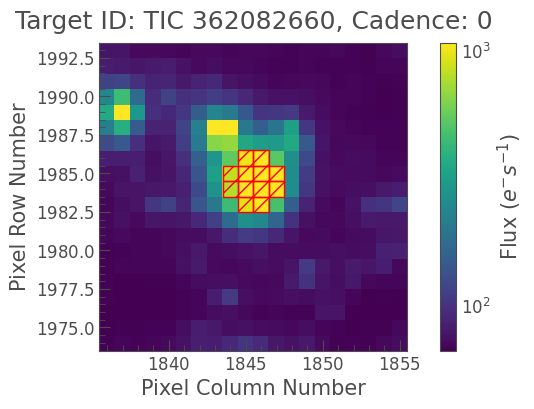

In [34]:
tpf = search_result[5].download(cutout_size=20) #Sector 52
lc52= create_lc(tpf, threshold=60, plot_mask=True)

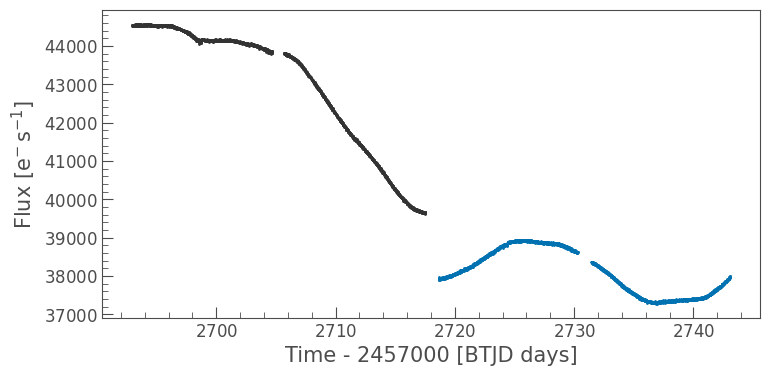

In [35]:
ax = lc51.scatter()
lc52.scatter(ax=ax);

Ah damn, even with using the same threshold for both these, there's still a gap

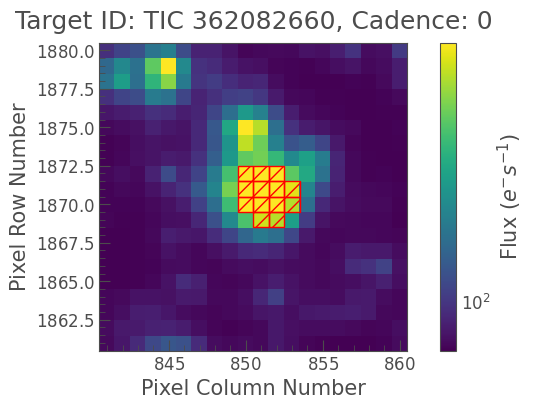

In [36]:
tpf = search_result[6].download(cutout_size=20) #Sector 53
lc53= create_lc(tpf, threshold=60, plot_mask=True)

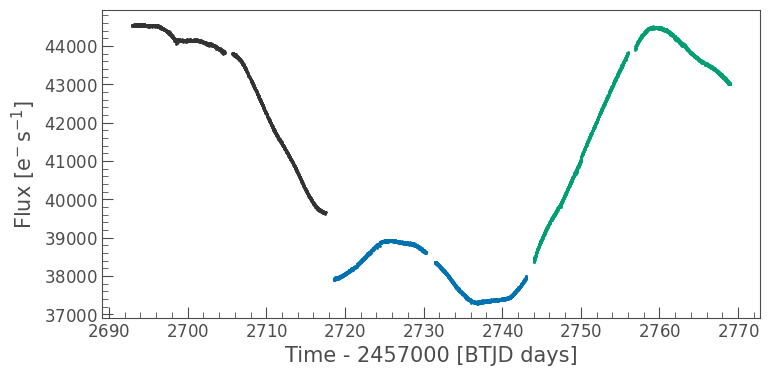

In [37]:
ax = lc51.scatter()
lc52.scatter(ax=ax);
lc53.scatter(ax=ax);